In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie

%matplotlib inline

In [2]:
input_path = '/home/hgrosselindemann/Documents/GitHub/TORI/'

grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
t = np.arange(datetime(2015,3,1,0,0,0), datetime(2015,4,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [4]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],t)
},data_vars={
    'u':(['y','x','time'],vel_data['u0_monthly']),
    'v':(['y','x','time'],vel_data['v0_monthly'])
})

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)

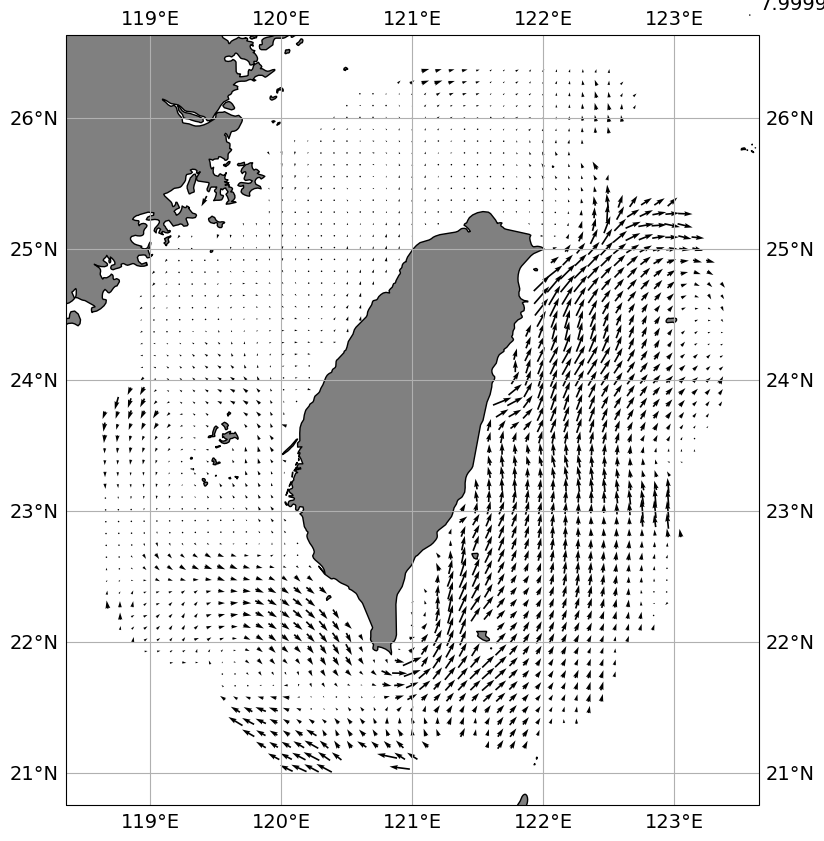

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.mean(dim='time').plot.quiver('lon','lat','u','v',ax=ax)
ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
ax.gridlines(draw_labels=True)

In [6]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ds.isel({framedim:tt}).plot.quiver('lon','lat','u','v',ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    ax.gridlines(draw_labels=True)
    return None,None
    
mov = Movie(velocity,custom_plotfunc,input_check=False)
mov.save('movie_2015.mp4',overwrite_existing=True,framerate=8)

Movie created at movie_2015.mp4


<Figure size 1000x1000 with 0 Axes>